In [2]:
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Robot_Arm:
    
    def __init__(self):
        self.P = np.array([0.0, 0.0, 0.3])          # Position Vector
        self.R = np.array([0.0, 0.0, 0.0])          # Rotation Vector (Orientation)
        self.d = np.array([0.050, 0.100, 0.100, 0.050])   # Arm link lengths in meters
        self.I = np.matrix([[1, 0, 0],           # Identity matrix
                            [0, 1, 0],
                            [0, 0, 1]])
        self.θ = np.array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])
        self.k = np.ones(3, dtype=np.int32)
    
    def forward(self, θ):
        T_list = [0,0,0,0,0,0,0]
        T01 = np.matrix([[np.cos(θ[0]),  0, -np.sin(θ[0]),    0],
                         [np.sin(θ[0]),  0,  np.cos(θ[0]),    0],
                         [           0, -1,             0, self.d[0]],
                         [           0,  0,             0,    1]])
        T_list[0] = T01
        T12 = np.matrix([[np.cos(θ[1]),  0,  np.sin(θ[1]),    0],
                         [np.sin(θ[1]),  0, -np.cos(θ[1]),    0],
                         [           0,  1,             0,    0],
                         [           0,  0,             0,    1]])
        T_list[1] = np.dot(T_list[0], T12)
        T23 = np.matrix([[np.cos(θ[2]),  0, -np.sin(θ[2]),    0],
                         [np.sin(θ[2]),  0,  np.cos(θ[2]),    0],
                         [           0, -1,             0, self.d[1]],
                         [           0,  0,             0,    1]])
        T_list[2] = np.dot(T_list[1], T23)
        T34 = np.matrix([[np.cos(θ[3]),  0,  np.sin(θ[3]),    0],
                         [np.sin(θ[3]),  0, -np.cos(θ[3]),    0],
                         [           0,  1,             0,    0],
                         [           0,  0,             0,    1]])
        T_list[3] = np.dot(T_list[2], T34)
        T45 = np.matrix([[np.cos(θ[4]),  0, -np.sin(θ[4]),    0],
                         [np.sin(θ[4]),  0,  np.cos(θ[4]),    0],
                         [           0, -1,             0, self.d[2]],
                         [           0,  0,             0,    1]])
        T_list[4] = np.dot(T_list[3], T45)
        T56 = np.matrix([[np.cos(θ[5]),  0,  np.sin(θ[5]),    0],
                         [np.sin(θ[5]),  0, -np.cos(θ[5]),    0],
                         [           0,  1,             0,    0],
                         [           0,  0,             0,    1]])
        T_list[5] = np.dot(T_list[4], T56)
        T67 = np.matrix([[np.cos(θ[6]), -np.sin(θ[6]),  0,    0],
                         [np.sin(θ[6]),  np.cos(θ[6]),  0,    0],
                         [           0,             0,  1, self.d[3]],
                         [           0,             0,  0,    1]])
        T_list[6] = np.dot(T_list[5], T67)
        return np.array(T_list)
    
    def get_xyz(self, t_list):
        X = np.zeros(8, dtype=np.int32)
        Y = np.zeros(8, dtype=np.int32)
        Z = np.zeros(8, dtype=np.int32)
        for i in range(7):
            X[i+1] = int(t_list[i,0,3]*1000)
            Y[i+1] = int(t_list[i,1,3]*1000)
            Z[i+1] = int(t_list[i,2,3]*1000)
        return X, Y, Z
    
    def magnitude(self, L):
        return np.sqrt(L.dot(L))
    
    # TODO: Figure out what this is for
    def GC(self, k):
        if (k == 2):
            return self.k[0]
        if (k == 4):
            return self.k[1]
        if (k == 6):
            return self.k[2]
        
    def inverse(self, P07, R07):
        P02 = np.array([0.0, 0.0, self.d[0]]).reshape(3,)
        P24 = np.array([0.0, 0.0, self.d[1]]).reshape(3,)
        P46 = np.array([0.0, 0.0, self.d[2]]).reshape(3,)
        P67 = np.array([0.0, 0.0, self.d[3]]).reshape(3,)
        θ_virt = np.zeros(7, dtype=np.float32)
        θ_virt[2] = 0.0 # Redundant, but helps illistrate the idea
        P26 = P07 - P02 - np.dot(R07, P67)
        print(' P26 = \n{}'.format(P26))
        P26_mag = self.magnitude(P26)
        print(' P26_mag = \n{}'.format(P26_mag))
        θ_virt[3] = self.GC(4) * math.acos((P26_mag**2 - self.d[1]**2 - self.d[2]**2) / (2 * self.d[1] * self.d[2]))
        print(' θ_virt[3] = \n{}'.format(θ_virt[3]))
        if (self.magnitude(np.cross(P26, R07[:,2])) >= 0):
            θ_virt[0] = np.arctan2(P26[1], P26[0])
        else:
            θ_virt[0] = 0.0
        print(' θ_virt[0] = \n{}'.format(θ_virt[0]))
        φ = np.arccos((self.d[1]**2 + P26_mag**2 - self.d[2]**2) / (2 * self.d[1] * P26_mag))
        print(' φ = {}'.format(φ))
        θ_virt[1] = np.arctan2(np.sqrt(P26[0]**2 + P26[1]**2), P26[2]) + self.GC(4) * φ
        print(' θ_virt[1] = \n{}'.format(θ_virt[1]))
        print(' θ_virt = \n{}'.format(θ_virt))
        P_virt_0 = self.forward(θ_virt)[:,:3,3]
        print(' P_virt_0 = \n{}'.format(P_virt_0))
        v_virt_sew = np.cross((P_virt_0[3].T - P_virt_0[1].T) / self.magnitude(P_virt_0[3].T- P_virt_0[1].T), (P_virt_0[5].T - P_virt_0[1].T) / self.magnitude(P_virt_0[5].T - P_virt_0[1].T))
        print(' v_virt_sew = \n{}'.format(v_virt_sew))
        v_virt_sew_hat = v_virt_sew / self.magnitude(v_virt_sew)
        print(' v_virt_sew_hat = \n{}'.format(v_virt_sew_hat))
        P_0 = self.forward(self.θ)[:,:3,3]
        print(' P_0 = \n{}'.format(P_0))
        v_sew = np.cross((P_0[3].T - P_0[1].T) / self.magnitude(P_0[3].T - P_0[1].T), (P_0[5].T - P_0[1].T) / self.magnitude(P_0[5].T - P_0[1].T))
        print(' v_sew = \n{}'.format(v_sew))
        v_sew_hat = v_sew / self.magnitude(v_sew)
        v_sew_hat[np.isnan(v_sew_hat)] = 0.0
        print(' v_sew_hat = \n{}'.format(v_sew_hat))
        sgψ = np.sign(np.dot(np.cross(v_virt_sew_hat, v_sew_hat), P26))
        print(' sgψ = \n{}'.format(sgψ))
        ψ = sgψ * math.acos(np.dot(v_virt_sew_hat, v_sew_hat))
        print(' ψ = \n{}'.format(ψ))
        I = np.array([[1.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0],
                      [0.0, 0.0, 1.0]])
        print(' I = \n{}'.format(I))
        P26_hat = P26 / P26_mag
        print(' P26_hat = \n{}'.format(P26_hat))
        P26_hat_cross = np.array([[        0.0, -P26_hat[2],  P26_hat[1]],
                                  [ P26_hat[2],         0.0, -P26_hat[0]],
                                  [-P26_hat[1],  P26_hat[0],         0.0]])
        print(' P26_hat_cross = \n{}'.format(P26_hat_cross))
        R_virt = self.forward(θ_virt)[:,:3,:3]
        print(' R_virt = \n{}'.format(R_virt))
        R0ψ = I + np.sin(ψ) * P26_hat_cross + (1 - np.cos(ψ)) * P26_hat_cross**2
        print(' R0ψ = \n{}'.format(R0ψ))
        As =  np.dot(P26_hat_cross, R_virt[2])
        print(' As = \n{}'.format(As))
        Bs = np.dot(-P26_hat_cross**2, R_virt[2])
        print(' Bs = \n{}'.format(Bs))
        Cs =  np.dot(np.dot(P26_hat, P26_hat.T), R_virt[2])
        print(' Cs = \n{}'.format(Cs))
        self.θ[0] = np.arctan2(self.GC(2)*(-As[1,1] * np.sin(ψ) - Bs[1,1] * np.cos(ψ) - Cs[1,1]), 
                               self.GC(2)*(-As[0,1] * np.sin(ψ) - Bs[0,1] * np.cos(ψ) - Cs[0,1]))
        print(' self.θ[0] = \n{}'.format(self.θ[0]))
        self.θ[1] = self.GC(2) * np.arccos(-As[2,1] * np.sin(ψ) - Bs[2,1] * np.cos(ψ) - Cs[2,1])
        print(' self.θ[1] = \n{}'.format(self.θ[1]))
        self.θ[2] = np.arctan2(self.GC(2)*(-As[2,2] * np.sin(ψ) - Bs[2,2] * np.cos(ψ) - Cs[2,2]), 
                               self.GC(2)*(-As[2,0] * np.sin(ψ) - Bs[2,0] * np.cos(ψ) - Cs[2,0]))
        print(' self.θ[2] = \n{}'.format(self.θ[2]))
        self.θ[3] = θ_virt[3]
        print(' self.θ[3] = \n{}'.format(self.θ[3]))
        R34 = np.matrix([[np.cos(self.θ[3]), 0,  np.sin(self.θ[3])],
                         [np.sin(self.θ[3]), 0, -np.cos(self.θ[3])],
                         [                0, 1,                  0]])
        print(' R34 = \n{}'.format(R34))
        print(' R07 shape = {}'.format(R07.shape))
        Aw = R34.T * As.T * R07
        print(' Aw = \n{}'.format(Aw))
        Bw = R34.T * Bs.T * R07
        print(' Bw = \n{}'.format(Bw))
        Cw = R34.T * Cs.T * R07
        print(' Cw = \n{}'.format(Cw))
        self.θ[4] = np.arctan2(self.GC(6)*(Aw[1,2] * np.sin(ψ) + Bw[1,2] * np.cos(ψ) + Cw[1,2]), 
                               self.GC(6)*(-Aw[0,2] * np.sin(ψ) - Bw[0,2] * np.cos(ψ) - Cw[0,2]))
        print(' self.θ[4] = \n{}'.format(self.θ[4]))
        self.θ[5] = self.GC(6) * np.arccos(Aw[2,2] * np.sin(ψ) + Bw[2,2] * np.cos(ψ) + Cw[2,2])
        print(' self.θ[5] = \n{}'.format(self.θ[5]))
        self.θ[6] = np.arctan2(self.GC(6)*(Aw[2,1] * np.sin(ψ) + Bw[2,1] * np.cos(ψ) + Cw[2,1]), 
                               self.GC(6)*(-Aw[2,0] * np.sin(ψ) - Bw[2,0] * np.cos(ψ) - Cw[2,0]))
        print(' self.θ[6] = \n{}'.format(self.θ[6]))
        return self.θ

In [4]:
def rad(deg):
    return (deg / 180) * np.pi


Running :: Rob Initialization

Running :: Initializing Targets
[-0.03266407 -0.03266407  0.21055553]
[[ 0.27059805 -0.70710678 -0.65328148]
 [ 0.27059805  0.70710678 -0.65328148]
 [ 0.92387953  0.          0.38268343]]
[[ 0.27059805 -0.70710678 -0.65328148 -0.03266407]
 [ 0.27059805  0.70710678 -0.65328148 -0.03266407]
 [ 0.92387953  0.          0.38268343  0.21055553]
 [ 0.          0.          0.          1.        ]]

Running :: Inverse Kinematics
 P26 = 
[4.00000000e-09 4.00000000e-09 1.41421359e-01]
 P26_mag = 
0.14142135850000012
 θ_virt[3] = 
1.570796251296997
 θ_virt[0] = 
0.7853981852531433
 φ = 0.7853981473978093
 θ_virt[1] = 
0.7853981852531433
 θ_virt = 
[0.7853982 0.7853982 0.        1.5707963 0.        0.        0.       ]
 P_virt_0 = 
[[0.         0.         0.05      ]
 [0.         0.         0.05      ]
 [0.05       0.05       0.12071068]
 [0.05       0.05       0.12071068]
 [0.1        0.1        0.05000001]
 [0.1        0.1        0.05000001]
 [0.125      0.125     

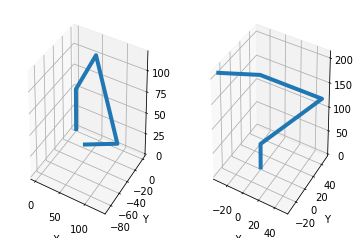

In [7]:
# Initialize Rob (AKA 'Robot' - 'ot')
print('\nRunning :: Rob Initialization')
rob = Robot_Arm()

# Create Target
print('\nRunning :: Initializing Targets')
P07 = np.array([-0.03266407, -0.03266407, 0.21055553]).reshape(3,)
R07 = np.array([[0.27059805, -0.70710678, -0.65328148],
                 [0.27059805,  0.70710678, -0.65328148],
                 [0.92387953,          0.,  0.38268343]])
xR07 = np.array([-0.65328148, -0.65328148, 0.38268343]).reshape(3,)
print(P07)
print(R07)
t_list = rob.forward([rad(45), rad(45), 0.0, rad(-90), 0.0, rad(-22.5), 0.0])
print(t_list[-1])

# Apply Inverse Kinematics
print('\nRunning :: Inverse Kinematics')
Q = rob.inverse(P07, R07)
print(Q)

# Apply Forward Kinematics
print('\nRunning :: Forward Kinematics')
t_list = rob.forward(Q)
print(t_list[-1])

# Get (x, y, z) position from base to end effector
print('\nRunning :: Get X, Y, Z')
X, Y, Z = rob.get_xyz(t_list)
print(X[-1])
print(Y[-1])
print(Z[-1])

# Plot Inverse Kinematics result
print('\nRunning :: Plotting')
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot(X, Y, Z, linewidth=4)
plt.xlabel('X')
plt.ylabel('Y')

# Apply Forward Kinematics to actual target for visualization
print('\nRunning :: True Forward Kinematics for Visualization')
t_list = rob.forward([rad(45), rad(45), 0.0, rad(-90), 0.0, rad(-22.5), 0.0])
print(t_list[-1])
X, Y, Z = rob.get_xyz(t_list)
ax = fig.add_subplot(122, projection='3d')
ax.plot(X, Y, Z, linewidth=4)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()